In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

## Import the jsonified transactions into a dataframe

In [2]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2017'
all_files = glob.glob(os.path.join(path, "*.json"))

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2018noaccount/'
all_files.append(glob.glob(os.path.join(path, "*.json")))

In [ ]:
all_files

In [3]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
for types in df.type.unique():
    print(types)    

In [4]:
df=df[df['type']=='Checkout']

In [5]:
df.drop(columns='type',inplace=True)

In [6]:
print("terminals (registers):",df.term.unique())

terminals (registers): [11  2  4  3  6 10  8  5  7  1  9]


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [7]:
df=df[df['term']<10]

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df['account'].fillna([],inplace=True)

In [ ]:
df.info()

In [ ]:
df = pd.concat([df,df2], axis=0, ignore_index=True)

In [8]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [9]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [10]:
pickle.dump(df,open('./data/pickles/df2017.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
df = pickle.load(open('./data/pickles/df2017.p','rb'))

In [ ]:
df.info()

In [ ]:
df.drop(columns='type',inplace=True)

In [41]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','8 OZ PLSTC TUB t3','16 OZ PLSTC TUB t4','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale',
                'PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    stopwords =[]
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    topics_list=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    '''if topics_list exist, add these to stopwords to reveal next layer down'''
    if topics_list:
        for topics in topics_list:
            for i in topics:
                stopwords.append(i)
            
    '''add predetermined stoppers to stopwords list'''
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords))
    #print(stopwords)
    stopwords_set = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords_set:
        if stops in items_set:
            items_set.remove(stops)
  

    return items_set,stopwords_set, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=15)

<class 'list'>


In [42]:
Counter(item_dict).most_common(50)

[('BAG CREDIT', 653976),
 ('SF Bag Charge', 202236),
 ('SMALL COOLER CRV', 199538),
 ('BANANAS', 128843),
 ('8 OZ BIO TUB t3', 62035),
 ('CRV LRG SING NOTAX', 61862),
 ('CRV SMALL NO TAX', 58056),
 ('CRV SMALL SING T', 52896),
 ('LEMONS', 43898),
 ('BOTTLE DEPOSIT', 42166),
 ('LARGE COOLER CRV', 40686),
 ('16OZ BIO TUB t4', 40682),
 ('AVOCADOS HASS', 39442),
 ('ONIONS YELLOW', 37568),
 ('CRV LRG SING T', 37409),
 ('CELERY', 37374),
 ('REFRIGERATED', 35442),
 ('BAGEL', 34216),
 ('CILANTRO', 33442),
 ('1lb STRAWBERRY', 33160),
 ('GINGER', 31682),
 ('APPLES FUJI', 28682),
 ('LIMES', 28666),
 ('BEER SMALL CRV', 28333),
 ('CUCUMBERS', 27661),
 ('GARLIC WHITE', 26969),
 ('Worker 20% PkgFood', 22556),
 ('5290 WALNUTS', 22393),
 ('CRV SML TAX NOEBT', 22197),
 ('TOMATO DRY FARM', 21247),
 ('PEACH', 21185),
 ('PEPPERS RED BELL', 19282),
 ('CARROTS LOOSE', 19047),
 ('6PACK BEER SMALL C', 18959),
 ('KALE DINO', 18907),
 ('ONIONS RED', 18822),
 ('SQUASH ZUCCHINI', 18245),
 ('GRAPEFRUIT', 17527),
 (

In [43]:
len(items_set)

25112

In [ ]:
df['items'].sample(10)

In [ ]:
df['item_count']=basket_counts

In [ ]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [ ]:
q1,q2,q3

In [ ]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [ ]:
df = df[df['item_count']>q2]

In [ ]:
df['item_count'].max()

In [ ]:
plt.scatter(dfq1['time'],dfq1['item_count'])

In [44]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [45]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [46]:
df.index

RangeIndex(start=0, stop=852986, step=1)

In [47]:
df=df.reset_index()

In [48]:
df.index

RangeIndex(start=0, stop=852986, step=1)

In [49]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items
count,852986.000000,852986.000000,852986.000000,852986.000000,852986.000000,852986.000000,852986.000000,852986.000000,852986.0
mean,426492.500000,64.918037,2.599467,62.321551,54.065636,4.290019,165.663796,6.485523,0.0
std,246235.992696,242.084655,230.494187,71.696879,28.495384,2.550239,118.451066,3.439721,0.0
min,0.000000,0.000000,0.000000,-500.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,213246.250000,17.080000,0.000000,16.770000,27.000000,2.000000,72.000000,4.000000,0.0
50%,426492.500000,40.690000,0.000000,40.070000,55.000000,4.000000,147.000000,7.000000,0.0
75%,639738.750000,83.520000,0.000000,82.070000,79.000000,6.000000,235.000000,9.000000,0.0
max,852985.000000,85628.780000,85577.490000,3692.860000,1745.000000,9.000000,728.000000,12.000000,0.0


In [50]:
df.pop('index')
print ()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852986 entries, 0 to 852985
Data columns (total 13 columns):
account           852986 non-null object
date              852986 non-null datetime64[ns]
gross+            852986 non-null float64
gross-            852986 non-null float64
items             852986 non-null object
net               852986 non-null float64
oper              852986 non-null int64
term              852986 non-null int64
time              852986 non-null object
trans             852986 non-null int64
day_of_week       852986 non-null object
month             852986 non-null int64
total_of_items    852986 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 84.6+ MB


In [52]:
df.iloc[:,0].index


RangeIndex(start=0, stop=852986, step=1)

In [53]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=852986, step=1)

In [54]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [55]:
col_index_dict['BANANAS']

KeyError: 'BANANAS'

In [56]:
df.shape[0]

852986

In [57]:
matrix_dict = defaultdict(int)
for i in range(df.shape[0]):
    for item in df['items'][i]:
        #set matrix to boolean for item precence in basket:
        #if item[1] not in stopwords and item[3] != 12:
        #if item[1] not in stopwords and item[3] not in (12,16):
        if item[1] not in stopwords:
            if item[2] > 0:
                value = 1
            elif item[2] == 0:
                value = 0
            else:
                value = -1
            matrix_dict[i,col_index_dict[item[1]]] += value

In [58]:
for item in items_set:
    if item.startswith('ONION'):
        print (item)

ONIONS YELLOW
ONION CIPOLLINI
ONIONS WHITE
ONIONS SWEET
ONIONS GREEN
ONION SACK
ONION GRUY CHZ RAV
ONION POWDER
ONION GRANULATES
ONIONS SPRING
ONIONS RED
ONION BIALYS


In [59]:
len(matrix_dict)

7109447

In [60]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

0
15798
1


In [61]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [ ]:
len(rows)

In [ ]:
import pickle

In [ ]:
sparse_matrix[4]

In [ ]:
pickle.dump(sparse_matrix,open('./data/pickles/sparse_matrix2015.p','wb'))

In [ ]:
pickle.dump(items_set,open('./data/pickles/items_set2015.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
file = open("./data/pickles/sparse_matrix2015.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [ ]:
file = open("./data/pickles/items_set2015.p",'rb')
items_set = pickle.load(file)
file.close()

In [62]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [63]:
sum_of_zeros=sum(np.sum(sparse_matrix,axis=1)==0)
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

[[0.0353898]] % of zero weight baskets


In [136]:
number_of_components=6

In [137]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=number_of_components,max_iter=250)

In [138]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 51 W shape: (852986, 6) H shape: (6, 25112)


In [139]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d srength: %f '%(i,t))

topic 0 srength: 0.140000 
topic 1 srength: 0.050000 
topic 2 srength: 0.540000 
topic 3 srength: 0.050000 
topic 4 srength: 0.170000 
topic 5 srength: 0.040000 


In [140]:
'''from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_'''

'from sklearn.decomposition import LatentDirichletAllocation as LDA\nmodel = LDA(n_components=2,max_iter=10)\nW = model.fit_transform(sparse_matrix)\nH = model.components_\nmodel.n_iter_'

In [141]:
feature_names=list(items_set).copy()
n_top_words=10
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[ 5700  5326 21401  3134  9343  2952 20245 15318  6003 20766]
['ONIONS YELLOW', 'GARLIC WHITE', 'APPLES FUJI', 'PEPPERS RED BELL', 'CARROTS LOOSE', 'SQUASH ZUCCHINI', 'ONIONS RED', 'TOMATO DRY FARM', 'BROCCOLI LOOSE', 'MUSHROOM CRIMINI']

[21705  9881 16928 21745 23171  1470 21852 11505 16715 13355]
['LEMONS', 'LIMES', 'SHALLOTS', 'GRAPEFRUIT', 'CUCUMBERS', 'CUKE MEDIT/PERSIAN', '5290 WALNUTS', 'FENNEL', 'BRUSSEL SPROUTS', 'PARSLEY ITALIAN']

[15232 10190  9513 10586  1019 21852 23171 19614  2185  1470]
['1lb STRAWBERRY', 'REFRIGERATED', 'PEACH', 'BAGEL', 'NECTARINE', '5290 WALNUTS', 'CUCUMBERS', 'blueberries pint', 'CORN', 'CUKE MEDIT/PERSIAN']

[10867 23171  9343 12376 21852 21745 11505  4490 15355 16715]
['CELERY', 'CUCUMBERS', 'CARROTS LOOSE', 'LEEKS', '5290 WALNUTS', 'GRAPEFRUIT', 'FENNEL', '5120 ORG ALMONDS', 'COLLARDS', 'BRUSSEL SPROUTS']

[14845 24680  9881 16928 24827 23171  4079 21852 21745 13066]
['CILANTRO', 'GINGER', 'LIMES', 'SHALLOTS', 'PEPPER CHILI', 'CUCUMBERS', 'ROOT 

In [142]:
pickle.dump(sparse_matrix,open('./data/pickles/topics_list2017.p','wb'))

0.14 Topic #0 of 6:
['ONIONS YELLOW', 'GARLIC WHITE', 'APPLES FUJI', 'PEPPERS RED BELL', 'CARROTS LOOSE', 'SQUASH ZUCCHINI', 'ONIONS RED', 'TOMATO DRY FARM', 'BROCCOLI LOOSE', 'MUSHROOM CRIMINI']


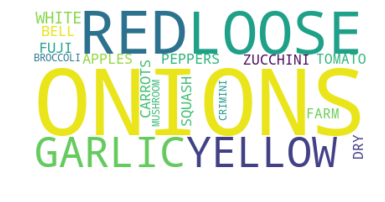

<img src="./img/2018/1554496508.topic0.png">
0.05 Topic #1 of 6:
['LEMONS', 'LIMES', 'SHALLOTS', 'GRAPEFRUIT', 'CUCUMBERS', 'CUKE MEDIT/PERSIAN', '5290 WALNUTS', 'FENNEL', 'BRUSSEL SPROUTS', 'PARSLEY ITALIAN']


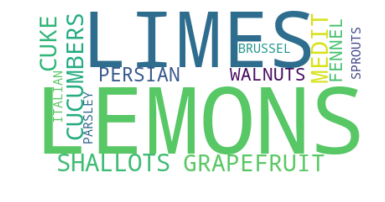

<img src="./img/2018/1554496509.topic1.png">
0.54 Topic #2 of 6:
['1lb STRAWBERRY', 'REFRIGERATED', 'PEACH', 'BAGEL', 'NECTARINE', '5290 WALNUTS', 'CUCUMBERS', 'blueberries pint', 'CORN', 'CUKE MEDIT/PERSIAN']


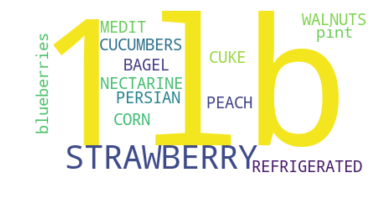

<img src="./img/2018/1554496509.topic2.png">
0.05 Topic #3 of 6:
['CELERY', 'CUCUMBERS', 'CARROTS LOOSE', 'LEEKS', '5290 WALNUTS', 'GRAPEFRUIT', 'FENNEL', '5120 ORG ALMONDS', 'COLLARDS', 'BRUSSEL SPROUTS']


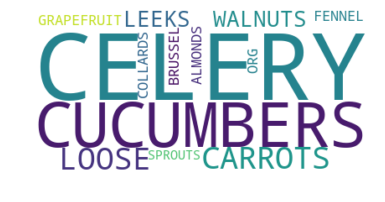

<img src="./img/2018/1554496510.topic3.png">
0.17 Topic #4 of 6:
['CILANTRO', 'GINGER', 'LIMES', 'SHALLOTS', 'PEPPER CHILI', 'CUCUMBERS', 'ROOT TURMERIC', '5290 WALNUTS', 'GRAPEFRUIT', 'ONIONS GREEN']


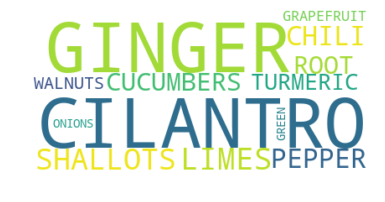

<img src="./img/2018/1554496510.topic4.png">
0.04 Topic #5 of 6:
['AVOCADOS HASS', 'TOMATO MIX HEIRLOO', 'APPLES FUJI', 'TOMATO DRY FARM', 'SPINACH LOOSE', 'PEPPERS RED BELL', 'KALE DINO', 'ARUGULA LOOSE', 'RASPBERRY', 'BROCCOLI LOOSE']


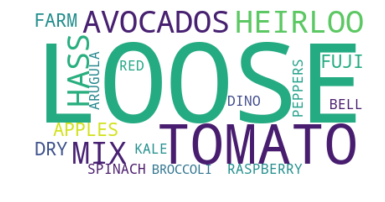

<img src="./img/2018/1554496511.topic5.png">
[['ONIONS YELLOW', 'GARLIC WHITE', 'APPLES FUJI', 'PEPPERS RED BELL', 'CARROTS LOOSE', 'SQUASH ZUCCHINI', 'ONIONS RED', 'TOMATO DRY FARM', 'BROCCOLI LOOSE', 'MUSHROOM CRIMINI'], ['LEMONS', 'LIMES', 'SHALLOTS', 'GRAPEFRUIT', 'CUCUMBERS', 'CUKE MEDIT/PERSIAN', '5290 WALNUTS', 'FENNEL', 'BRUSSEL SPROUTS', 'PARSLEY ITALIAN'], ['1lb STRAWBERRY', 'REFRIGERATED', 'PEACH', 'BAGEL', 'NECTARINE', '5290 WALNUTS', 'CUCUMBERS', 'blueberries pint', 'CORN', 'CUKE MEDIT/PERSIAN'], ['CELERY', 'CUCUMBERS', 'CARROTS LOOSE', 'LEEKS', '5290 WALNUTS', 'GRAPEFRUIT', 'FENNEL', '5120 ORG ALMONDS', 'COLLARDS', 'BRUSSEL SPROUTS'], ['CILANTRO', 'GINGER', 'LIMES', 'SHALLOTS', 'PEPPER CHILI', 'CUCUMBERS', 'ROOT TURMERIC', '5290 WALNUTS', 'GRAPEFRUIT', 'ONIONS GREEN'], ['AVOCADOS HASS', 'TOMATO MIX HEIRLOO', 'APPLES FUJI', 'TOMATO DRY FARM', 'SPINACH LOOSE', 'PEPPERS RED BELL', 'KALE DINO', 'ARUGULA LOOSE', 'RASPBERRY', 'BROCCOLI LOOSE']]


In [143]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics_list =[]
    for topic_idx, topic in enumerate(model.components_):
        print(topic_strength[topic_idx],"Topic #%d of %d:" %( topic_idx,number_of_components))
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics_list.append(topic_string)
        print(topic_string)
        #print()
        #wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace("'","").replace(",",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        img_time=str(time.time()).split('.')[0]
        wordcloud.to_file('./img/2018/%s.topic%d.png'%(img_time,topic_idx))
        print('<img src="./img/2018/%s.topic%d.png">'%(img_time,topic_idx))
    return topic_dict,topics_list

topic_dict,topics_list = print_top_items(model,list(items_set),n_top_words)
print(topics_list)

In [144]:
topics3=topic_dict.copy()

In [145]:
topic_compare = np.zeros([len(topic_dict),len(topic_dict)])

for topic in topic_dict:
    for item in topic_dict[topic]:
        for topic2 in topic_dict:
            if item in topic_dict[topic2]:
                topic_compare[topic,topic2]+=1
print (topic_strength)            
print(topic_compare)


[0.14 0.05 0.54 0.05 0.17 0.04]
[[10.  0.  0.  1.  0.  4.]
 [ 0. 10.  3.  5.  5.  0.]
 [ 0.  3. 10.  2.  2.  0.]
 [ 1.  5.  2. 10.  3.  0.]
 [ 0.  5.  2.  3. 10.  0.]
 [ 4.  0.  0.  0.  0. 10.]]


In [146]:
list_of_topics=[]
for topic in topic_dict:
     list_of_topics.append(topic_dict[topic])

In [147]:
topic_matrix=np.array(topics_list).T
topic_matrix.shape

(10, 6)

In [151]:
pd.DataFrame(topic_matrix,columns=topic_strength).to_pickle('./data/pickles/2017topics%d.pkl'%number_of_components)

In [152]:
topic_df = pd.DataFrame(topic_matrix,columns=topic_strength)

In [153]:
import tabulate 


In [154]:
print(tabulate.tabulate(topic_df.values,topic_df.columns, tablefmt="pipe")) 

| 0.14             | 0.05               | 0.54               | 0.05             | 0.17          | 0.04               |
|:-----------------|:-------------------|:-------------------|:-----------------|:--------------|:-------------------|
| ONIONS YELLOW    | LEMONS             | 1lb STRAWBERRY     | CELERY           | CILANTRO      | AVOCADOS HASS      |
| GARLIC WHITE     | LIMES              | REFRIGERATED       | CUCUMBERS        | GINGER        | TOMATO MIX HEIRLOO |
| APPLES FUJI      | SHALLOTS           | PEACH              | CARROTS LOOSE    | LIMES         | APPLES FUJI        |
| PEPPERS RED BELL | GRAPEFRUIT         | BAGEL              | LEEKS            | SHALLOTS      | TOMATO DRY FARM    |
| CARROTS LOOSE    | CUCUMBERS          | NECTARINE          | 5290 WALNUTS     | PEPPER CHILI  | SPINACH LOOSE      |
| SQUASH ZUCCHINI  | CUKE MEDIT/PERSIAN | 5290 WALNUTS       | GRAPEFRUIT       | CUCUMBERS     | PEPPERS RED BELL   |
| ONIONS RED       | 5290 WALNUTS       | CUCUMB

In [ ]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

In [ ]:
len(ing_set)

In [ ]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [ ]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [ ]:
ingredients.shape

In [ ]:
ing_matrix=np.zeros(ingredients.shape)

In [ ]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

In [ ]:
ing_array=ing_index_dict.values()

ing_array

In [ ]:
for i in ing_matrix:
    print(ing_array==i)

In [ ]:
for ing_index_dict

In [ ]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [ ]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

In [ ]:
df['item_count'].max()

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [ ]:
len(list(items_set))

In [ ]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df['CILANTRO'][10:11]

In [ ]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df.shape

In [ ]:
df.to_pickle('02012019.pkl')

In [ ]:
len(items_set)

In [ ]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

In [ ]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

In [ ]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [ ]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

In [ ]:
df[['gross+','time']].plot()
plt.show()

In [ ]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

In [ ]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [ ]:
df=pd.read_pickle('02012019.pkl')

In [ ]:
df[df['BANANAS']!=0]

In [ ]:
df.columns

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

In [ ]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

In [ ]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

In [ ]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
df.info()

In [ ]:
plt.scatter(dfq1['item_count'],dfq1['term'])